In [2]:
!pip install neuralprophet

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [3]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import warnings

#Import Prophet model
from neuralprophet import NeuralProphet, set_log_level, set_random_seed

#Import logging
import logging


set_log_level("ERROR")
logging.getLogger("prophet").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")


import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.


In [4]:
# Data source: https://www.kaggle.com/datasets/sushobhitlutade/inventorysupply-chain-managementscm-superstore/data?select=Brand.csv
# US holiday 2004-2021 data: https://www.kaggle.com/datasets/donnetew/us-holiday-dates-2004-2021?select=US+Holiday+Dates+%282004-2021%29.csv

#Importing and cleaning data

In [5]:
#download data
# https://drive.google.com/file/d/1zLUFEgysYJIL0oAA7WIiv0eogs8xUel7/view?usp=sharing
# https://drive.google.com/file/d/1gevzcsdgYnpcMVUJBhOe3z6QsIPK7GJZ/view?usp=sharing

dwn_url='https://drive.google.com/uc?id='
# df_id = dwn_url+"1zLUFEgysYJIL0oAA7WIiv0eogs8xUel7"
df_trans = pd.read_csv(dwn_url+"1zLUFEgysYJIL0oAA7WIiv0eogs8xUel7") #transactions data

#deletes white spaces on column tittles
df_trans.columns = [col.strip() for col in df_trans.columns]

#Clean transaction table, delete unnecessary columns (Payment_Method, Customer_Cart, Cashier)
df_trans = df_trans.drop(columns=['Payment_Method', 'CustomerCart_CustomerID','Cashier_CashierID','Subtotal', 'Taxes', 'DiscountPrice','TotalAmount'])

#transforms date column to datetime format
df_trans["Transaction_date"] = pd.to_datetime(df_trans["Transaction_date"], format = "%Y-%m-%d")

#Clean data to show only 2014-2017 data
df_trans=df_trans[df_trans["Transaction_date"].dt.year <= 2017]


In [6]:
#create column for Units Sold
df_trans['Units_Sold'] = df_trans['Quantity']

#delete column named 'Quantity' for better column lableling/understanding
df_trans = df_trans.drop(columns=['Quantity'])

#add columns to Transaction Table
df_trans['Category_ID']= df_trans['Products_ProductID'].str[:6] #Initials of category and subcategory
df_trans['Month']= df_trans['Transaction_date'].dt.month
df_trans['Day_of_Year']= df_trans['Transaction_date'].dt.day_of_year
df_trans['Year-Month'] = df_trans['Transaction_date'].dt.to_period('M')
df_trans['Day_of_the_Week']= df_trans['Transaction_date'].dt.day_name()


In [7]:
df_trans.head()

,Transaction_date,Products_ProductID,Units_Sold,Category_ID,Month,Day_of_Year,Year-Month,Day_of_the_Week
0,2016-11-11,FUR-BO-10001798,2,FUR-BO,11,316,2016-11,Friday
1,2016-11-11,FUR-CH-10000454,3,FUR-CH,11,316,2016-11,Friday
2,2016-06-16,OFF-LA-10000240,2,OFF-LA,6,168,2016-06,Thursday
3,2015-10-18,FUR-TA-10000577,5,FUR-TA,10,291,2015-10,Sunday
4,2015-10-18,OFF-ST-10000760,2,OFF-ST,10,291,2015-10,Sunday


In [8]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9952 entries, 0 to 9993
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Transaction_date    9952 non-null   datetime64[ns]
 1   Products_ProductID  9952 non-null   object        
 2   Units_Sold          9952 non-null   int64         
 3   Category_ID         9952 non-null   object        
 4   Month               9952 non-null   int32         
 5   Day_of_Year         9952 non-null   int32         
 6   Year-Month          9952 non-null   period[M]     
 7   Day_of_the_Week     9952 non-null   object        
dtypes: datetime64[ns](1), int32(2), int64(1), object(3), period[M](1)
memory usage: 622.0+ KB


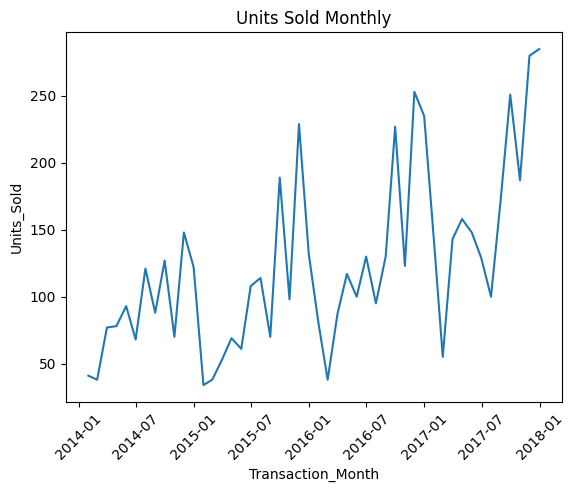

In [9]:
df_OFF_BI = df_trans.query("`Category_ID` == 'OFF-BI'")

# Grouping data by number of units sold each week
df_M = df_OFF_BI.groupby(pd.Grouper(key="Transaction_date", freq='M'))[['Units_Sold']].sum().reset_index()

# Plotting dataframe
plt.plot(df_M["Transaction_date"], df_M['Units_Sold'])
plt.ylabel('Units_Sold')
plt.xlabel('Transaction_Month')
plt.xticks(rotation=45)
plt.title('Units Sold Monthly')
plt.show()

In [10]:
#Renaming Columns to meet Neural Prophet format - Weekly
df_M.columns = ['ds', 'y']
df_M.head()

,ds,y
0,2014-01-31,41
1,2014-02-28,38
2,2014-03-31,77
3,2014-04-30,78
4,2014-05-31,93


#Training Model

In [11]:
df_train_M = df_M[df_M['ds']<='2017-5-31']
df_test_M = df_M[df_M['ds']>'2017-5-31']

set_random_seed(42)


m = NeuralProphet()
m.set_plotting_backend('plotly-static')
model = m.fit(df_train_M, freq="M", epochs=1000).tail()

print("Model summary:\n", model) # Print the model summary

#df_train is not defined....I dont think the right model is being fitted

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/203 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Model summary:
      train_loss  reg_loss        MAE       RMSE      Loss  RegLoss  epoch
995    0.008185       0.0  11.605952  14.451566  0.007115      0.0    995
996    0.008185       0.0  11.153603  13.702363  0.007005      0.0    996
997    0.008183       0.0  14.222955  17.177855  0.008634      0.0    997
998    0.008178       0.0  11.114188  13.965610  0.006997      0.0    998
999    0.008177       0.0  13.178355  15.926059  0.008041      0.0    999


Predicting: |          | 0/? [00:00<?, ?it/s]

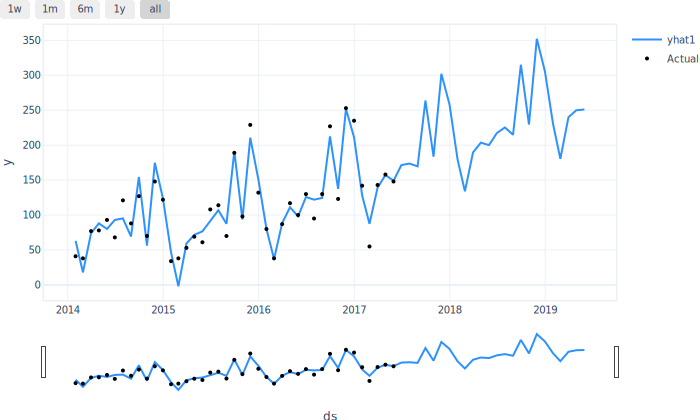

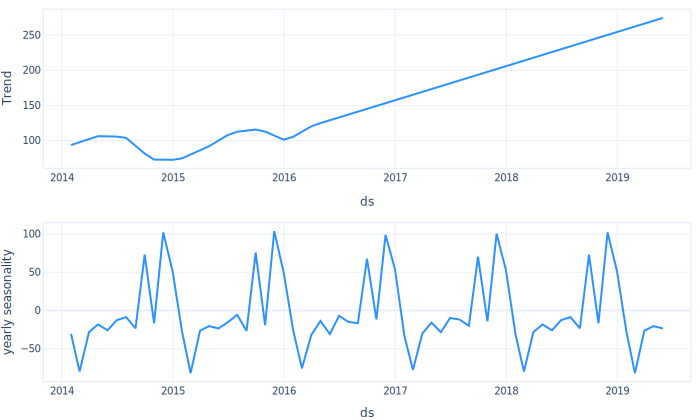

In [12]:
future = m.make_future_dataframe(df=df_train_M, periods=24, n_historic_predictions=len(df_train_M))
forecast = m.predict(future)

# Plot the forecast
fig_forecast = m.plot(forecast)

# Plot the forecast components
fig_components = m.plot_components(forecast)


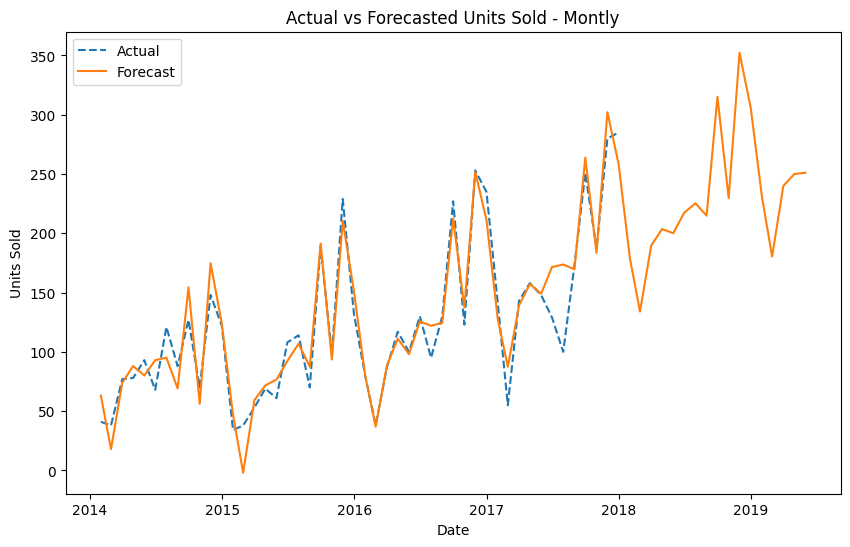

In [13]:
# Compare Actuals vs Forecast to investigate
plt.figure(figsize=(10, 6))
plt.plot(df_M['ds'], df_M['y'], label='Actual', linestyle='dashed')
plt.plot(forecast['ds'], forecast['yhat1'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('Actual vs Forecasted Units Sold - Montly')
plt.legend()
plt.show()

#Adding complexity to model:
- Seasonality
- Trend
- freequency
- Holidays

### 3-Phase Train, validate and Test evaluation

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/203 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

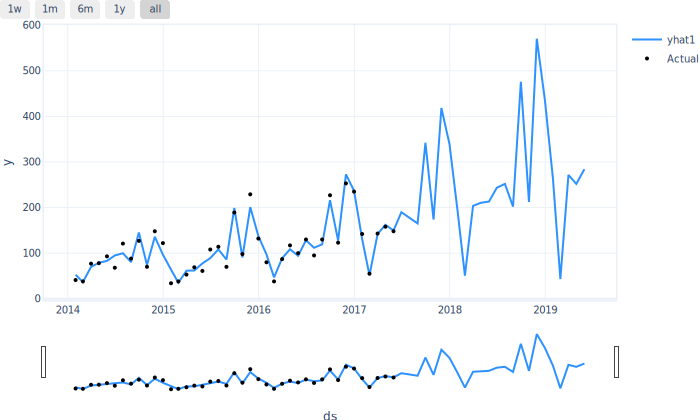

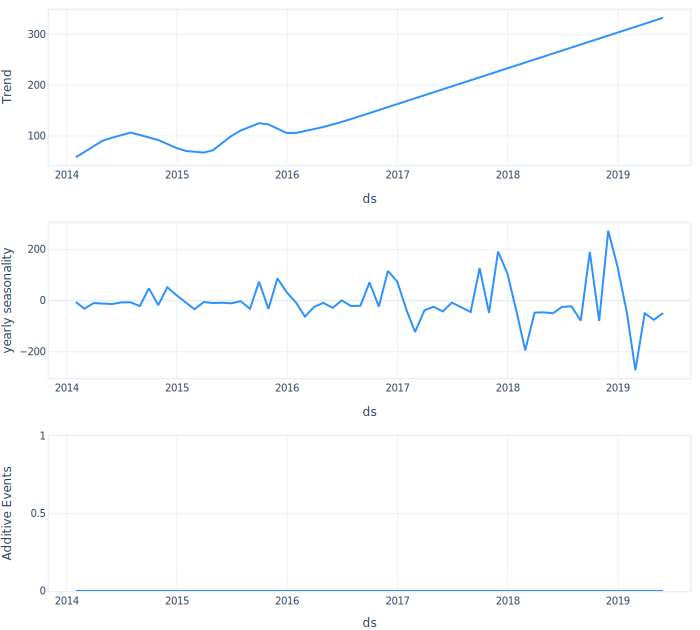

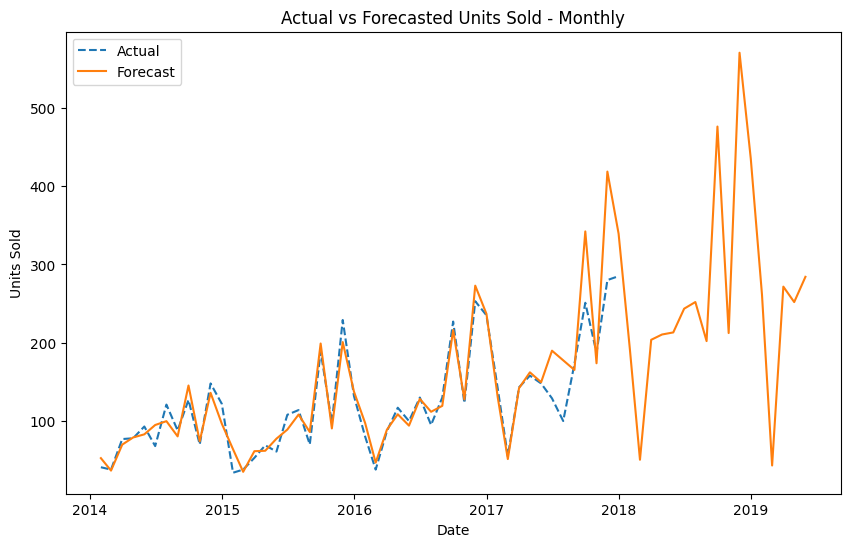

In [14]:
# Re-initialize NeuralProphet for weekly model fitting

# Splitting data into training and test sets
df_train_M = df_M[df_M['ds']<='2017-5-31']
df_test_M = df_M[df_M['ds']>'2017-5-31']

set_random_seed(42)

m_M = NeuralProphet(
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
)
m_M = m_M.add_country_holidays(country_name='US')
m_M.set_plotting_backend('plotly-static')
m_M.fit(df_train_M, freq="M", epochs=1000)

future_M = m_M.make_future_dataframe(df=df_train_M,
                                       periods=24,
                                       n_historic_predictions=len(df_train_M))
forecast_M = m_M.predict(future_M)

# Plotting the forecast for weekly data
fig_forecast = m_M.plot(forecast_M)

# Plotting the forecast components for weekly data
fig_components = m_M.plot_components(forecast_M)

# Additional plot to compare actual vs forecasted for weekly data
plt.figure(figsize=(10, 6))
plt.plot(df_M['ds'], df_M['y'], label='Actual', linestyle='dashed')
plt.plot(forecast_M['ds'], forecast_M['yhat1'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('Actual vs Forecasted Units Sold - Monthly')
plt.legend()
plt.show()

Cross-validation weekly

In [15]:
# Define metrics and parameters for weekly data
METRICS_M = ["MAE", "RMSE"]
METRICS_VAL_M = ["MAE_val", "RMSE_val"]
params_M = {"seasonality_mode": "multiplicative","yearly_seasonality":True}

# Split data into folds for weekly data
folds_M = NeuralProphet(**params_M).crossvalidation_split_df(df_M, freq="M", k=5, fold_pct=0.1, fold_overlap_pct=0.5)

# Train and evaluate across folds for weekly data
metrics_train_M = pd.DataFrame(columns=METRICS_M)
metrics_test_M = pd.DataFrame(columns=METRICS_VAL_M)

for df_train, df_test in folds_M:
    m = NeuralProphet(**params_M)
    m.set_plotting_backend("plotly-static")
    train = m.fit(df=df_train_M, freq="M")
    test = m.test(df=df_test_M)

    # Collect metrics for weekly data
    metrics_train_M = pd.concat([metrics_train_M, train[METRICS_M].iloc[-1].to_frame().T])
    metrics_test_M = pd.concat([metrics_test_M, test[METRICS_VAL_M].iloc[-1].to_frame().T])

# Calculate average metrics for weekly data
avg_metrics_train_M = metrics_train_M.mean()
avg_metrics_test_M = metrics_test_M.mean()

print("Average Training Metrics (Weekly):", avg_metrics_train_M)
print("Average Testing Metrics (Weekly):", avg_metrics_test_M)

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/203 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.3213508427143097     │
│          MAE_val          │     86.57598876953125     │
│         RMSE_val          │    103.98843383789062     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/203 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.3155762255191803     │
│          MAE_val          │     84.88287353515625     │
│         RMSE_val          │    101.87293243408203     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/203 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    1.5165680646896362     │
│          MAE_val          │     324.9807434082031     │
│         RMSE_val          │    349.91448974609375     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/203 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.2683529555797577     │
│          MAE_val          │     75.06092834472656     │
│         RMSE_val          │     91.16486358642578     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/203 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.2768154442310333     │
│          MAE_val          │     76.6073226928711      │
│         RMSE_val          │     92.81919860839844     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Average Training Metrics (Weekly): MAE     34.018318
RMSE    40.433938
dtype: float64
Average Testing Metrics (Weekly): MAE_val     129.621571
RMSE_val    147.951984
dtype: float64
